# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Introducción
**Motivación para el desarrollo de un modelo de clasificación de residuos para reciclaje:**

En el contexto de la creciente generación de residuos sólidos, es fundamental implementar soluciones inteligentes que permitan automatizar su clasificación. El desafío consiste en desarrollar un sistema capaz de analizar una imagen y detectar automáticamente el tipo de residuo presente (como metal, plástico, vidrio, cartón, papel o basura no reciclable).

Esta clasificación precisa es clave para:

- Asignar el tratamiento adecuado a cada tipo de residuo (reciclaje, compostaje, disposición final, etc.).
- Mejorar la eficiencia en la gestión de residuos urbanos e industriales.
- Reducir el impacto ambiental, promoviendo la economía circular y el cuidado del medio ambiente.

El objetivo final es contribuir a una gestión sostenible de residuos mediante el uso de tecnologías de visión por computadora e inteligencia artificial.

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image, UnidentifiedImageError
import kagglehub
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.feature import canny
from imblearn.over_sampling import RandomOverSampler
import torch
from torchvision import transforms
import pandas as pd

Descarga del dataset mediante `kagglehub`:

In [2]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet")
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

Path to dataset files: /home/ggf/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


## EDA: Análisis Exploratorio de Datos
El análisis exploratorio de datos se ataca teniendo en cuenta que el objetivo es clasificación de imágenes y no detección de objetos (no se analizan bounding boxes).

### Estructura del dataset

In [3]:
trash_cls = os.listdir(dataset_path)
print("Class directories:", trash_cls)
for cls in trash_cls:
    print(f"Example file {cls}:", os.listdir(os.path.join(dataset_path, cls))[0])

Class directories: ['paper', 'cardboard', 'plastic', 'metal', 'glass', 'trash']
Example file paper: paper412.jpg
Example file cardboard: cardboard325.jpg
Example file plastic: plastic174.jpg
Example file metal: metal127.jpg
Example file glass: glass197.jpg
Example file trash: trash64.jpg


Las clases disponibles en el dataset, y por lo tanto la clasificación a realizar, son:
- Papel
- Carton
- Plástico
- Metal
- Vidrio
- Basura

En la sección [Tratamiento de residuos](#tratamiento-de-residuos) se brinda más información sobre la clasificación de estos residuos.

- El etiquetado de las imágenes ya se encuentra resuelto por el proveedor del dataset.
- Cada imagen tiene una única etiqueta.
- También se observa que las imágenes del dataset son jpg.

### Visualización de imágenes

A continuación se visualiza una imágen ejemplo del dataset para cada clase:

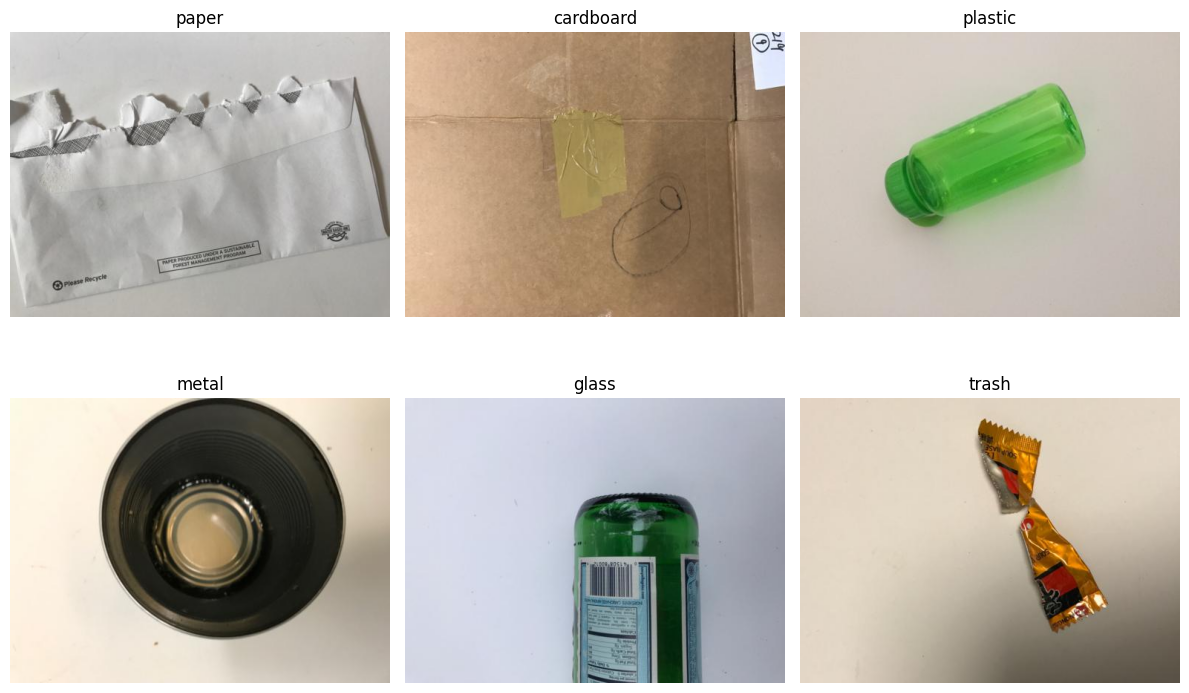

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, cls in zip(axes.flatten(), trash_cls):
    cls_path = os.path.join(dataset_path, cls)
    ax.imshow(Image.open(os.path.join(cls_path, os.listdir(cls_path)[0])))
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Análisis de integridad de imagenes

In [5]:
for cls in trash_cls:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, img_name))
            img.verify()
        except (UnidentifiedImageError, IOError):
            print(f"Error opening image {img_name} in class {cls}")
            continue
else:
    print(f"All images are valid.")

All images are valid.


- Todas las imágenes del dataset son utilizables. No hay problemas de corrupción o imágenes inválidas.

A continuación se utiliza un índice de similaridad de imágenes para detectar posibles duplicados:

In [6]:
# CODIGO COMENTADO UNICAMENTE POR EL TIEMPO DE EJECUCION
# def compare_images(img1, img2):
#     img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#     return ssim(img1, img2)


# for cls in trash_cls:
#     cls_path = os.path.join(dataset_path, cls)
#     images = os.listdir(cls_path)
#     loaded_images = [cv2.imread(os.path.join(cls_path, img)) for img in images]

#     for i in range(len(images)):
#         for j in range(i + 1, len(images)):
#             similarity = compare_images(loaded_images[i], loaded_images[j])
#             if similarity > 0.95:
#                 print(
#                     f"Possible duplicate: {images[i]} / {images[j]} in {cls} (SSIM: {similarity:.2f})"
#                 )

- No existen imagenes duplicadas en el dataset.

### Análisis de distribución de etiquetas

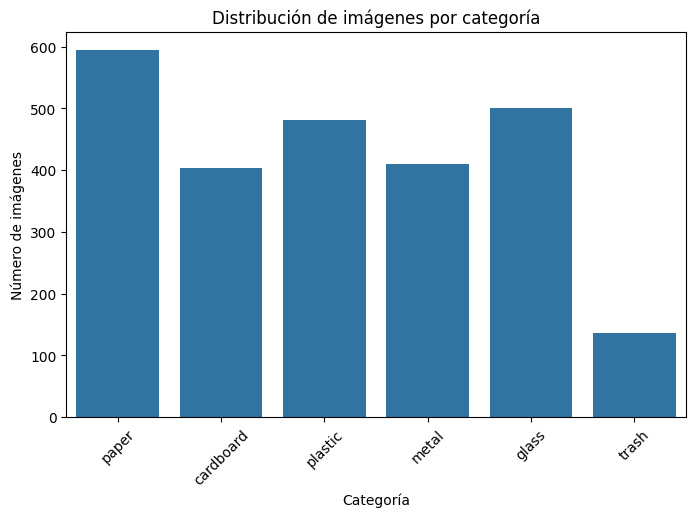

Total number of images: 2527
Number of images in paper: 594
Number of images in cardboard: 403
Number of images in plastic: 482
Number of images in metal: 410
Number of images in glass: 501
Number of images in trash: 137


In [7]:
image_counts = [len(os.listdir(os.path.join(dataset_path, cls))) for cls in trash_cls]
plt.figure(figsize=(8, 5))
sns.barplot(x=trash_cls, y=image_counts)
plt.xlabel("Categoría")
plt.ylabel("Número de imágenes")
plt.title("Distribución de imágenes por categoría")
plt.xticks(rotation=45)
plt.show()

print("Total number of images:", sum(image_counts))
for cls, count in zip(trash_cls, image_counts):
    print(f"Number of images in {cls}: {count}")

Se puede observar que el dataset tiene desbalance de clases. El desbalance se aprecia principalmente por la poca cantidad de imágenes con clase "trash" y una gran cantidad de imágenes con clase "paper" (al menos 90 imágenes más que el resto de categorías).

### Dimensiones de imagenes y relación de aspecto

In [8]:
image_sizes = []
for cls in trash_cls:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, img_name))
            img.verify()
        except (UnidentifiedImageError, IOError):
            print(f"Error opening image {img_name} in class {cls}")
            continue
        image_sizes.append(img.size)

print("Image sizes:", set(image_sizes))

Image sizes: {(512, 384)}


- Todas las imágenes del dataset tienen exactamente el mismo tamaño 512x384. Esto simplifica su uso.
- La relación de aspecto será 512/384 = 1.33

### Aplicación de data augmentation

1. Incrementar el tamaño de conjunto de datos
2. Evitar el sobreentrenamiento
3. Permite balancear las clases del conjunto de datos
4. Mejorar las métricas del modelo

Se realiza data augmentation sobre la clase minoritaria. Se aplican transformaciones de rotación y espejo, que para los datos en estudio no afectan las características de los objetos a clasificar.

TODO: Considerar el sesgo que puede introducir el background al rotar

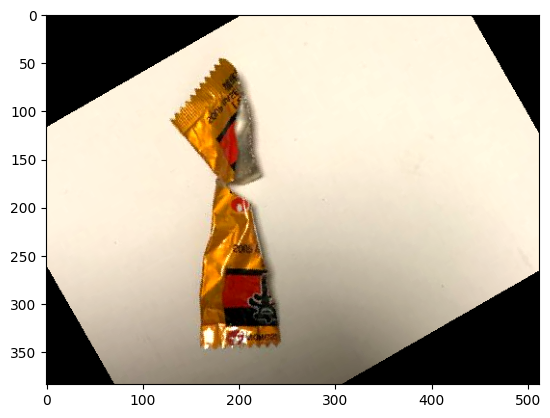

In [9]:
trash_path = os.path.join(dataset_path, "trash")
image_name = os.listdir(trash_path)[0]

img = Image.open(os.path.join(trash_path, image_name))

# Se aplica transformaciones de aumento de datos
augment = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

augmented_img = augment(img)
plt.imshow(augmented_img)

In [10]:
# Ajuste del peso de las clases en el modelo
# Pesos inversamente proporcionales al número de imágenes en cada clase
class_weights = torch.tensor([1/410, 1/501, 1/594, 1/137, 1/403, 1/482])

# Se aplica los pesos en la función de pérdida
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

In [11]:
categories = os.listdir(dataset_path)

X = []
labels = []

for cls in trash_cls:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        X.append(img_name)
        labels.append(cls)

X = np.array(X)
labels = np.array(labels)

oversampler = RandomOverSampler(sampling_strategy='auto')
X_resampled, y_resampled = oversampler.fit_resample(X.reshape(-1, 1), labels)

In [12]:
num_images = len(os.listdir(os.path.join(dataset_path, "trash")))
print(f"Número de imágenes en 'trash' después del oversampling: {num_images}")

Número de imágenes en 'trash' después del oversampling: 137


In [13]:
print("Número de imágenes antes del oversampling:", len(X))
print("Número de imágenes después del oversampling:", len(X_resampled))

Número de imágenes antes del oversampling: 2527
Número de imágenes después del oversampling: 3564


In [14]:
import shutil
import random
import math

trash_path = os.path.join(dataset_path, "trash")
output_path = os.path.join(os.getcwd(), "trash_augmented")

if os.path.exists(output_path):
    print("Output directory already exists. Removing it...")
    shutil.rmtree(output_path)
os.makedirs(output_path, exist_ok=True)

existing_images = os.listdir(trash_path)
num_existing = len(existing_images)

target_count = max([410, 501, 594, 403, 482])  # Máximo de imágenes en otras categorías

print(f"Imágenes originales: {num_existing}")
print(f"Objetivo: {target_count}")

copies_needed = target_count - num_existing

if copies_needed <= 0:
    print("No se necesitan copias adicionales.")
else:
    copies_per_image = math.ceil(copies_needed / num_existing)

    print(f"Copiando {copies_needed} imágenes...")

    for img_name in existing_images:
        shutil.copy(os.path.join(trash_path, img_name),
                   os.path.join(output_path, img_name))

    count = num_existing
    for i in range(copies_needed):
        img_name = random.choice(existing_images)
        new_name = f"augmented_{i}_{img_name}"
        shutil.copy(os.path.join(trash_path, img_name),
                   os.path.join(output_path, new_name))
        count += 1

        if i % 50 == 0:
            print(f"Progreso: {count}/{target_count} imágenes")

        if count >= target_count:
            break

final_count = len(os.listdir(output_path))
print("Número total de imágenes después del balanceo:", final_count)

Output directory already exists. Removing it...
Imágenes originales: 137
Objetivo: 594
Copiando 457 imágenes...
Progreso: 138/594 imágenes
Progreso: 188/594 imágenes
Progreso: 238/594 imágenes
Progreso: 288/594 imágenes
Progreso: 338/594 imágenes
Progreso: 388/594 imágenes
Progreso: 438/594 imágenes
Progreso: 488/594 imágenes
Progreso: 538/594 imágenes
Progreso: 588/594 imágenes
Número total de imágenes después del balanceo: 594


Se evidencia desbalanceo, por ende se corrige con nuevo script

In [15]:
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs(output_path)

existing_images = os.listdir(trash_path)
num_existing = len(existing_images)

target_count = max([410, 501, 594, 403, 482])  # Máximo de imágenes en otras categorías

print(f"Imágenes originales: {num_existing}")
print(f"Objetivo: {target_count}")

copies_needed = target_count - num_existing

print("Copiando imágenes originales...")
for img_name in existing_images:
    shutil.copy(os.path.join(trash_path, img_name),
               os.path.join(output_path, img_name))

count = num_existing
print(f"Copiadas {count} imágenes originales")

if copies_needed <= 0:
    print("No se necesitan copias adicionales.")
else:
    print(f"Creando {copies_needed} copias adicionales...")

    for i in range(copies_needed):
        # Selecciona una imagen al azar para balancear mejor
        img_name = random.choice(existing_images)
        new_name = f"augmented_{i}_{img_name}"
        shutil.copy(os.path.join(trash_path, img_name),
                   os.path.join(output_path, new_name))
        count += 1


        if count >= target_count:
            break

final_count = len(os.listdir(output_path))
print("Número total de imágenes después del balanceo:", final_count)

final_count = len(os.listdir(output_path))
print("Número total de imágenes después del balanceo:", final_count)

Imágenes originales: 137
Objetivo: 594
Copiando imágenes originales...
Copiadas 137 imágenes originales
Creando 457 copias adicionales...
Número total de imágenes después del balanceo: 594
Número total de imágenes después del balanceo: 594


Conteo de imágenes por categoría en el dataset original:
- glass: 501 imágenes
- paper: 594 imágenes
- cardboard: 403 imágenes
- plastic: 482 imágenes
- metal: 410 imágenes
- trash: 137 imágenes

Categoría 'trash' balanceada: 594 imágenes


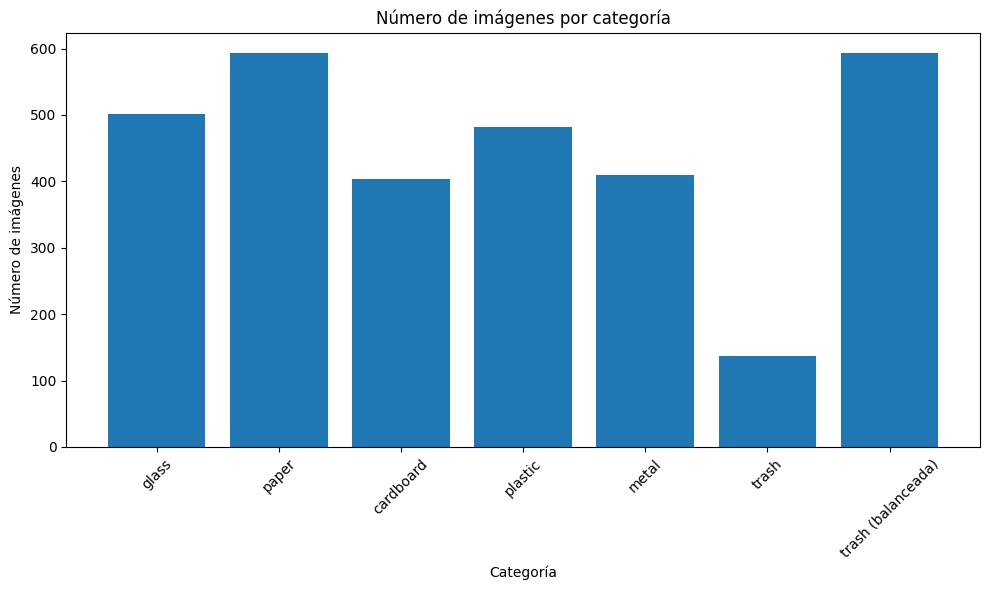


Creando dataset balanceado completo...
- Copiada categoría 'glass': 501 imágenes
- Copiada categoría 'paper': 594 imágenes
- Copiada categoría 'cardboard': 403 imágenes
- Copiada categoría 'plastic': 482 imágenes
- Copiada categoría 'metal': 410 imágenes
- Copiada categoría 'trash' balanceada: 594 imágenes

Verificación del dataset balanceado final:
- glass: 501 imágenes
- paper: 594 imágenes
- cardboard: 403 imágenes
- plastic: 482 imágenes
- metal: 410 imágenes
- trash: 1049 imágenes


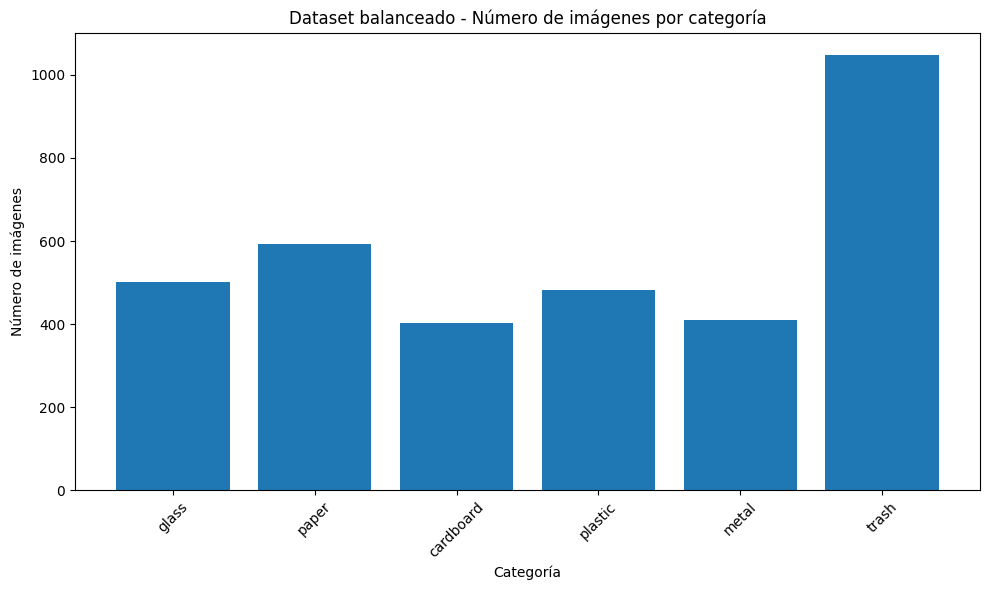


El dataset balanceado está disponible en: /home/ggf/workspace/ceia/ceia-vpc2/balanced_dataset


In [16]:
import matplotlib.pyplot as plt
import numpy as np

original_dataset_path = dataset_path
working_dir = os.getcwd()
balanced_dataset_path = os.path.join(working_dir, "balanced_dataset")

os.makedirs(balanced_dataset_path, exist_ok=True)

categories = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

print("Conteo de imágenes por categoría en el dataset original:")
counts = {}
for category in categories:
    category_path = os.path.join(original_dataset_path, category)
    if os.path.exists(category_path):
        count = len(os.listdir(category_path))
        counts[category] = count
        print(f"- {category}: {count} imágenes")

trash_augmented_path = os.path.join(working_dir, "trash_augmented")
if os.path.exists(trash_augmented_path):
    count = len(os.listdir(trash_augmented_path))
    print(f"\nCategoría 'trash' balanceada: {count} imágenes")

plt.figure(figsize=(10, 6))
categories_list = list(counts.keys())
counts_list = list(counts.values())

if os.path.exists(trash_augmented_path):
    categories_list.append('trash (balanceada)')
    counts_list.append(len(os.listdir(trash_augmented_path)))

plt.bar(categories_list, counts_list)
plt.title('Número de imágenes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nCreando dataset balanceado completo...")

for category in categories:
    if category != 'trash':
        source_dir = os.path.join(original_dataset_path, category)
        target_dir = os.path.join(balanced_dataset_path, category)

        os.makedirs(target_dir, exist_ok=True)

        for file in os.listdir(source_dir):
            shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

        print(f"- Copiada categoría '{category}': {len(os.listdir(source_dir))} imágenes")

if os.path.exists(trash_augmented_path):
    target_dir = os.path.join(balanced_dataset_path, 'trash')

    os.makedirs(target_dir, exist_ok=True)

    for file in os.listdir(trash_augmented_path):
        shutil.copy(os.path.join(trash_augmented_path, file), os.path.join(target_dir, file))

    print(f"- Copiada categoría 'trash' balanceada: {len(os.listdir(trash_augmented_path))} imágenes")

print("\nVerificación del dataset balanceado final:")
for category in categories:
    category_path = os.path.join(balanced_dataset_path, category)
    if os.path.exists(category_path):
        count = len(os.listdir(category_path))
        print(f"- {category}: {count} imágenes")

plt.figure(figsize=(10, 6))
final_counts = []
for category in categories:
    category_path = os.path.join(balanced_dataset_path, category)
    if os.path.exists(category_path):
        final_counts.append(len(os.listdir(category_path)))
    else:
        final_counts.append(0)

plt.bar(categories, final_counts)
plt.title('Dataset balanceado - Número de imágenes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nEl dataset balanceado está disponible en: {balanced_dataset_path}")

Se tiene relativamente balanceado dataset,  con tecnica de Data Augmentation

In [18]:
categories = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

def load_image_metadata(dataset_path, limit_per_category=None):
    image_data = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            continue

        image_files = os.listdir(category_path)
        if limit_per_category:
            image_files = image_files[:limit_per_category]

        print(f"Procesando {len(image_files)} imágenes de la categoría '{category}'...")

        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            try:
                with Image.open(img_path) as img_pil:
                    width, height = img_pil.size
                    format_img = img_pil.format
                    mode = img_pil.mode

                img_cv = cv2.imread(img_path)
                if img_cv is None:
                    continue

                img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

                aspect_ratio = width / height if height > 0 else 0

                img_small = cv2.resize(img_rgb, (50, 50))  # Redimensionar para acelerar, puede ser otro valor
                pixels = img_small.reshape(-1, 3)

                brightness = np.mean(img_small)

                contrast = np.std(img_small)

                edges = canny(cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY), sigma=2)
                if np.any(edges):
                    y_indices, x_indices = np.where(edges)
                    if len(x_indices) > 0 and len(y_indices) > 0:
                        x_min, x_max = np.min(x_indices), np.max(x_indices)
                        y_min, y_max = np.min(y_indices), np.max(y_indices)
                        bb_width = x_max - x_min
                        bb_height = y_max - y_min
                        bb_area = bb_width * bb_height
                        bb_coverage = bb_area / (width * height) if width * height > 0 else 0
                    else:
                        bb_width, bb_height, bb_area, bb_coverage = 0, 0, 0, 0
                else:
                    bb_width, bb_height, bb_area, bb_coverage = 0, 0, 0, 0

                hist_r = np.histogram(img_rgb[:,:,0], bins=8, range=(0,256))[0]
                hist_g = np.histogram(img_rgb[:,:,1], bins=8, range=(0,256))[0]
                hist_b = np.histogram(img_rgb[:,:,2], bins=8, range=(0,256))[0]

                image_data.append({
                    'filename': img_file,
                    'category': category,
                    'width': width,
                    'height': height,
                    'aspect_ratio': aspect_ratio,
                    'format': format_img,
                    'mode': mode,
                    'brightness': brightness,
                    'contrast': contrast,
                    'bb_width': bb_width,
                    'bb_height': bb_height,
                    'bb_area': bb_area,
                    'bb_coverage': bb_coverage,
                    'hist_r': hist_r,
                    'hist_g': hist_g,
                    'hist_b': hist_b
                })
            except Exception as e:
                print(f"Error procesando {img_path}: {e}")

    return pd.DataFrame(image_data)

df_images = load_image_metadata(balanced_dataset_path)
print(f"Se han cargado {len(df_images)} imágenes para el análisis.")

Procesando 501 imágenes de la categoría 'glass'...
Procesando 594 imágenes de la categoría 'paper'...
Procesando 403 imágenes de la categoría 'cardboard'...
Procesando 482 imágenes de la categoría 'plastic'...
Procesando 410 imágenes de la categoría 'metal'...
Procesando 1049 imágenes de la categoría 'trash'...
Se han cargado 3439 imágenes para el análisis.


### Anáslisis de distribución de etiquetas
Nuevo análisis de distribución de etiquetas luego de solucionar desbalanceo.

category
trash        1049
paper         594
glass         501
plastic       482
metal         410
cardboard     403
Name: count, dtype: int64


/tmp/ipykernel_353801/2360448269.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='category', data=df_images, palette='viridis')


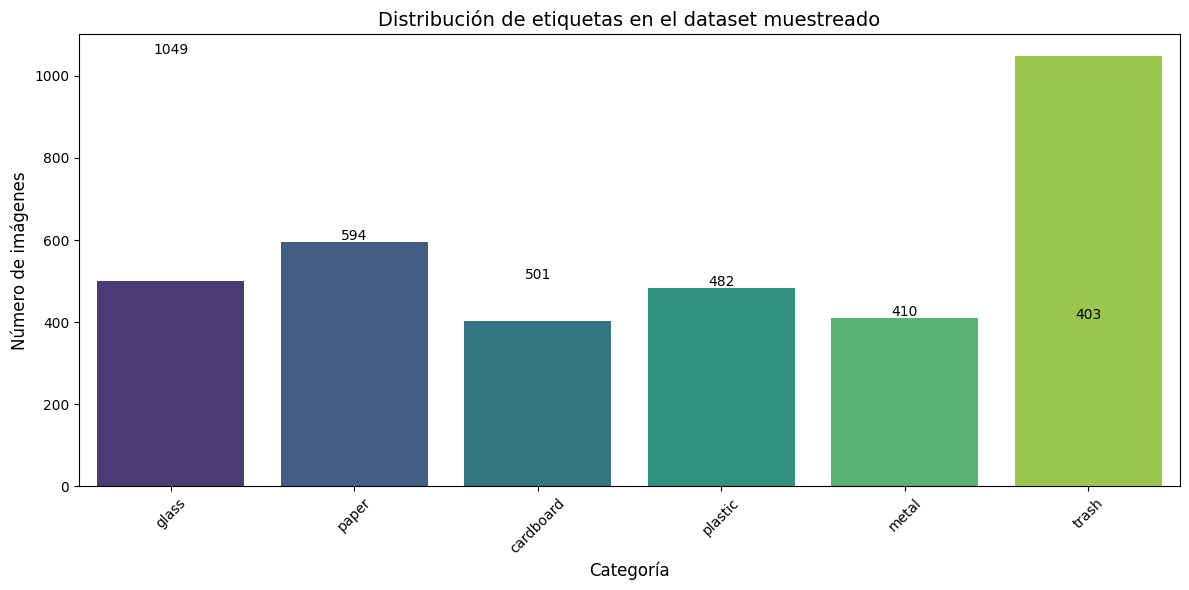

In [19]:
label_counts = df_images['category'].value_counts()
print(label_counts)

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='category', data=df_images, palette='viridis')
plt.title('Distribución de etiquetas en el dataset muestreado', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Número de imágenes', fontsize=12)
plt.xticks(rotation=45)

for i, count in enumerate(label_counts.values):
    ax.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

Este muestreo equilibrado permitirá hacer comparaciones justas entre categorías en los análisis posteriores de color, dimensiones, bounding boxes y calidad, sin que los resultados estén sesgados por la cantidad desigual de imágenes.

### Análisis de bounding boxes

Estadísticas de bounding boxes:
          bb_width    bb_height       bb_area  bb_coverage
count  3439.000000  3439.000000    3439.00000  3439.000000
mean    344.189881   283.971794  103103.09683     0.524409
std     118.384038    83.901460   52478.51614     0.266920
min       0.000000     0.000000       0.00000     0.000000
25%     258.000000   228.000000   59555.00000     0.302912
50%     350.000000   296.000000   99835.00000     0.507787
75%     446.000000   364.000000  146160.00000     0.743408
max     509.000000   381.000000  193929.00000     0.986374


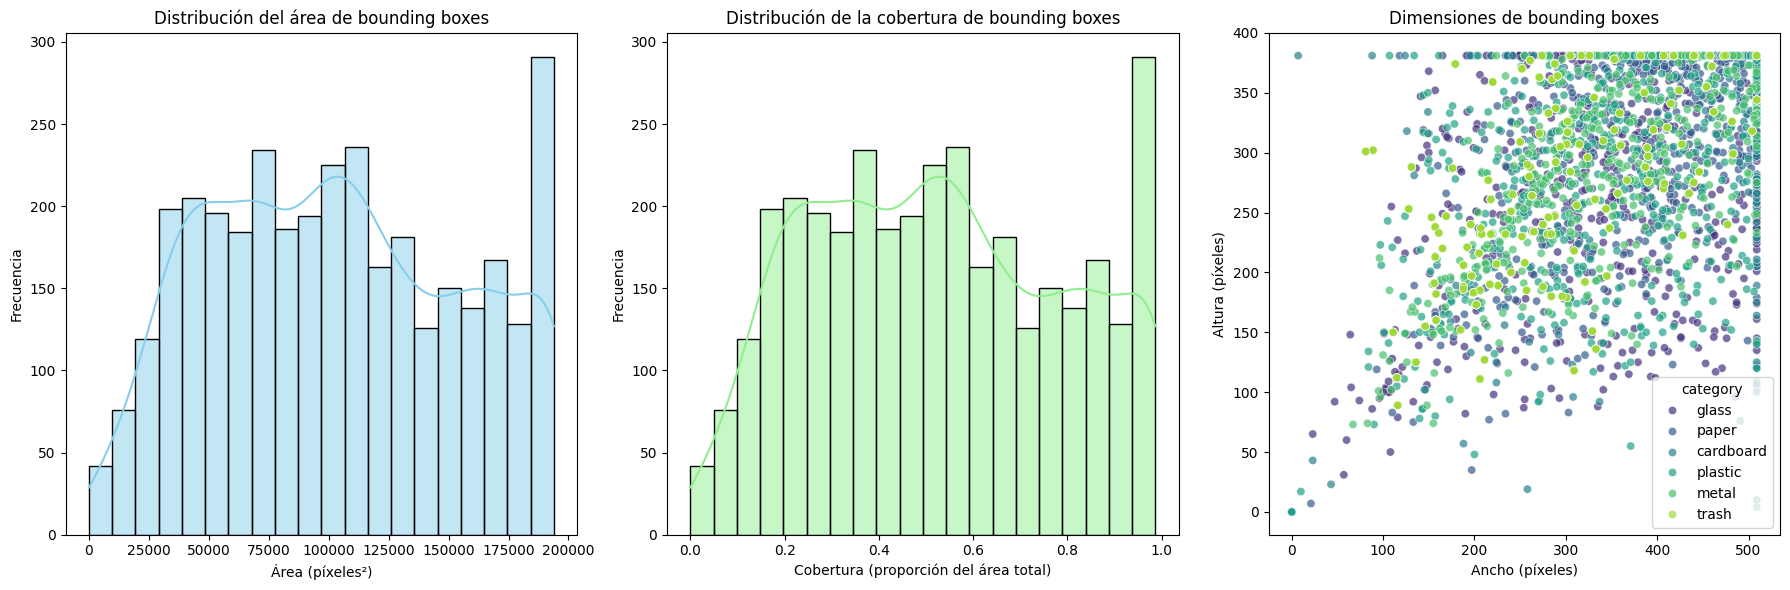

/tmp/ipykernel_353801/3137779838.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='bb_coverage', data=df_images, palette='viridis')


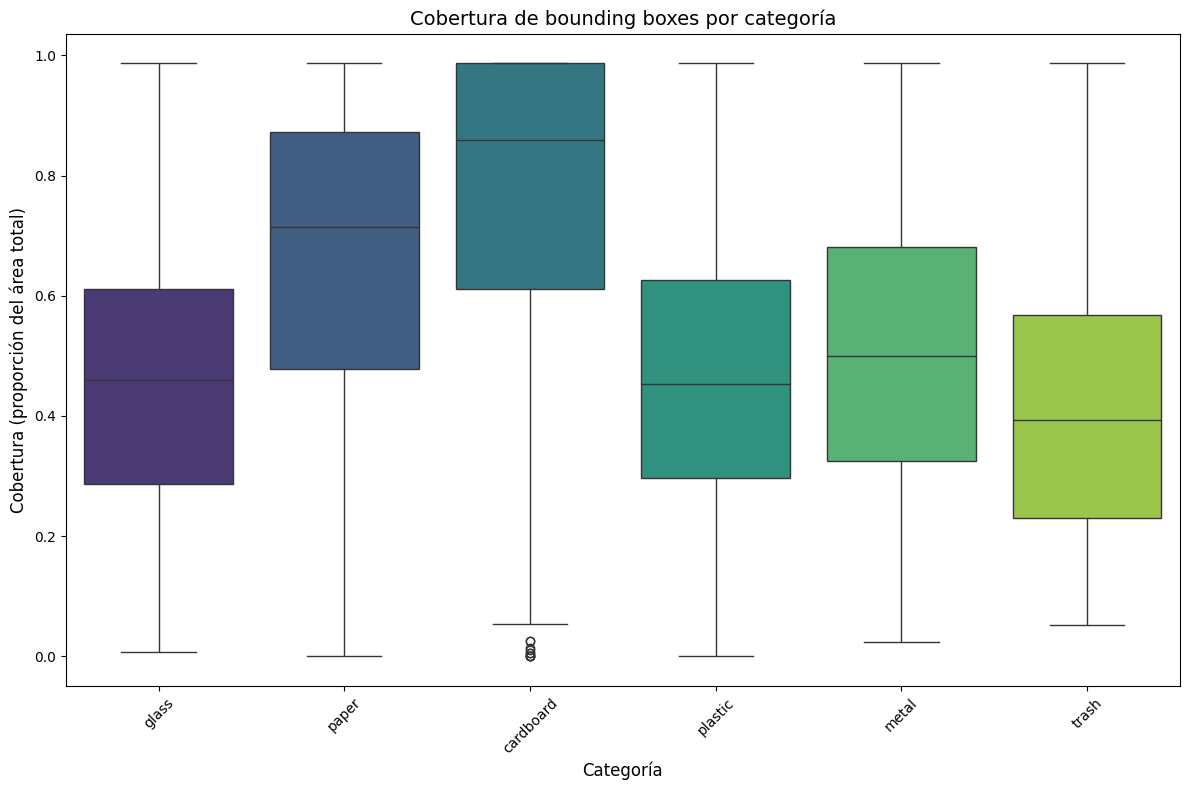

In [20]:
print("Estadísticas de bounding boxes:")
print(df_images[['bb_width', 'bb_height', 'bb_area', 'bb_coverage']].describe())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_images['bb_area'], bins=20, kde=True, color='skyblue')
plt.title('Distribución del área de bounding boxes', fontsize=12)
plt.xlabel('Área (píxeles²)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.subplot(1, 3, 2)
sns.histplot(df_images['bb_coverage'], bins=20, kde=True, color='lightgreen')
plt.title('Distribución de la cobertura de bounding boxes', fontsize=12)
plt.xlabel('Cobertura (proporción del área total)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.subplot(1, 3, 3)
sns.scatterplot(x='bb_width', y='bb_height', hue='category', data=df_images, palette='viridis', alpha=0.7)
plt.title('Dimensiones de bounding boxes', fontsize=12)
plt.xlabel('Ancho (píxeles)', fontsize=10)
plt.ylabel('Altura (píxeles)', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='bb_coverage', data=df_images, palette='viridis')
plt.title('Cobertura de bounding boxes por categoría', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cobertura (proporción del área total)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Análisis de distribución de colores

Estadísticas de brillo y contraste:
        brightness     contrast
count  3439.000000  3439.000000
mean    163.549399    48.453991
std      19.815638    14.929588
min      76.897333     9.566588
25%     151.684800    38.399094
50%     167.963333    47.956980
75%     177.060000    58.441927
max     224.442533    99.017257


/tmp/ipykernel_353801/3867658571.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='brightness', data=df_images, palette='viridis')
/tmp/ipykernel_353801/3867658571.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='contrast', data=df_images, palette='viridis')


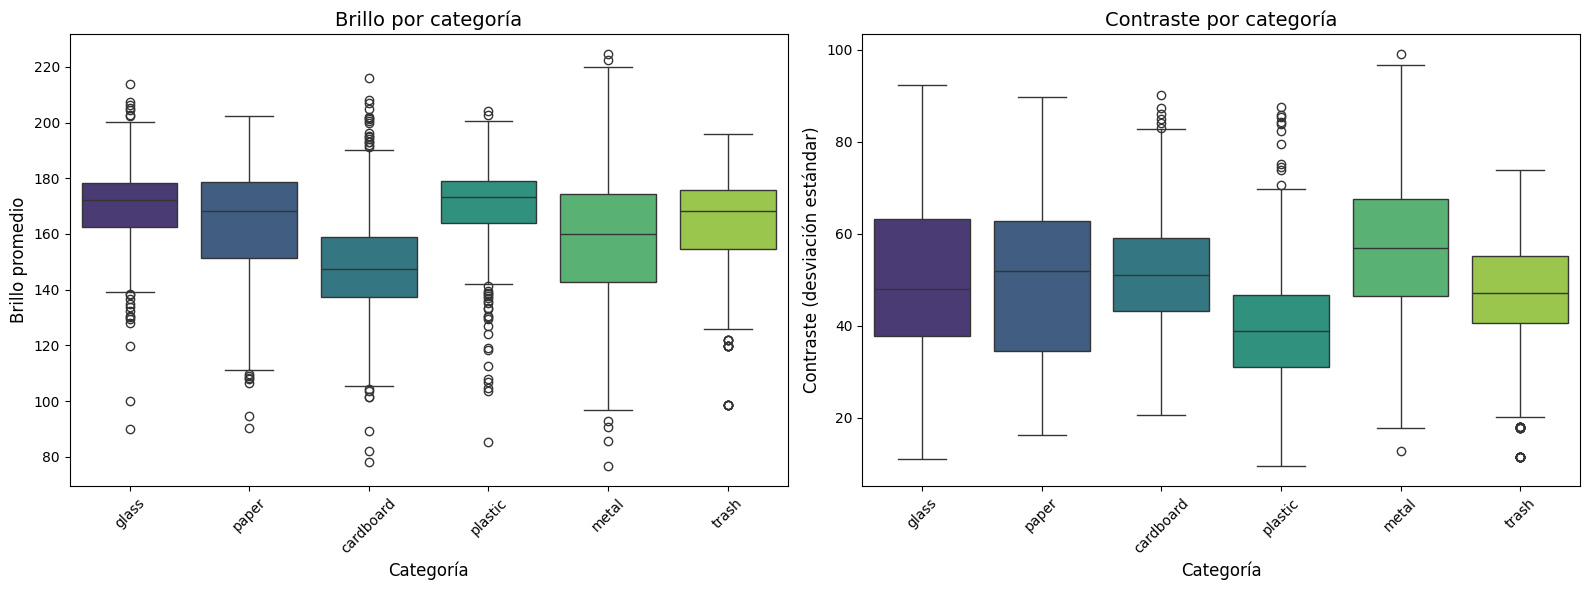

In [21]:
print("Estadísticas de brillo y contraste:")
print(df_images[['brightness', 'contrast']].describe())

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='category', y='brightness', data=df_images, palette='viridis')
plt.title('Brillo por categoría', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Brillo promedio', fontsize=12)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='category', y='contrast', data=df_images, palette='viridis')
plt.title('Contraste por categoría', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Contraste (desviación estándar)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

def plot_avg_rgb_hist(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        category_df = df[df['category'] == category]
        if len(category_df) == 0:
            continue

        avg_hist_r = np.mean(np.stack(category_df['hist_r'].values), axis=0)
        avg_hist_g = np.mean(np.stack(category_df['hist_g'].values), axis=0)
        avg_hist_b = np.mean(np.stack(category_df['hist_b'].values), axis=0)

        avg_hist_r = avg_hist_r / np.sum(avg_hist_r) if np.sum(avg_hist_r) > 0 else avg_hist_r
        avg_hist_g = avg_hist_g / np.sum(avg_hist_g) if np.sum(avg_hist_g) > 0 else avg_hist_g
        avg_hist_b = avg_hist_b / np.sum(avg_hist_b) if np.sum(avg_hist_b) > 0 else avg_hist_b

        bins = np.linspace(0, 255, 9)  # 8 bins
        bin_centers = (bins[:-1] + bins[1:]) / 2

        axes[i].bar(bin_centers, avg_hist_r, color='red', alpha=0.5, width=30, label='R')
        axes[i].bar(bin_centers, avg_hist_g, color='green', alpha=0.5, width=30, label='G')
        axes[i].bar(bin_centers, avg_hist_b, color='blue', alpha=0.5, width=30, label='B')

        axes[i].set_title(f'Histograma RGB promedio - {category}', fontsize=12)
        axes[i].set_xlabel('Valor de pixel', fontsize=10)
        axes[i].set_ylabel('Frecuencia relativa', fontsize=10)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

### Análisis de calidad de imágenes

Estadísticas de score de calidad:
count    3439.000000
mean        0.019502
std         0.047628
min         0.001208
25%         0.004794
50%         0.007230
75%         0.014373
max         0.625502
Name: quality_score, dtype: float64


/tmp/ipykernel_353801/2708139118.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="category", y="quality_score", data=df_images, palette="viridis")


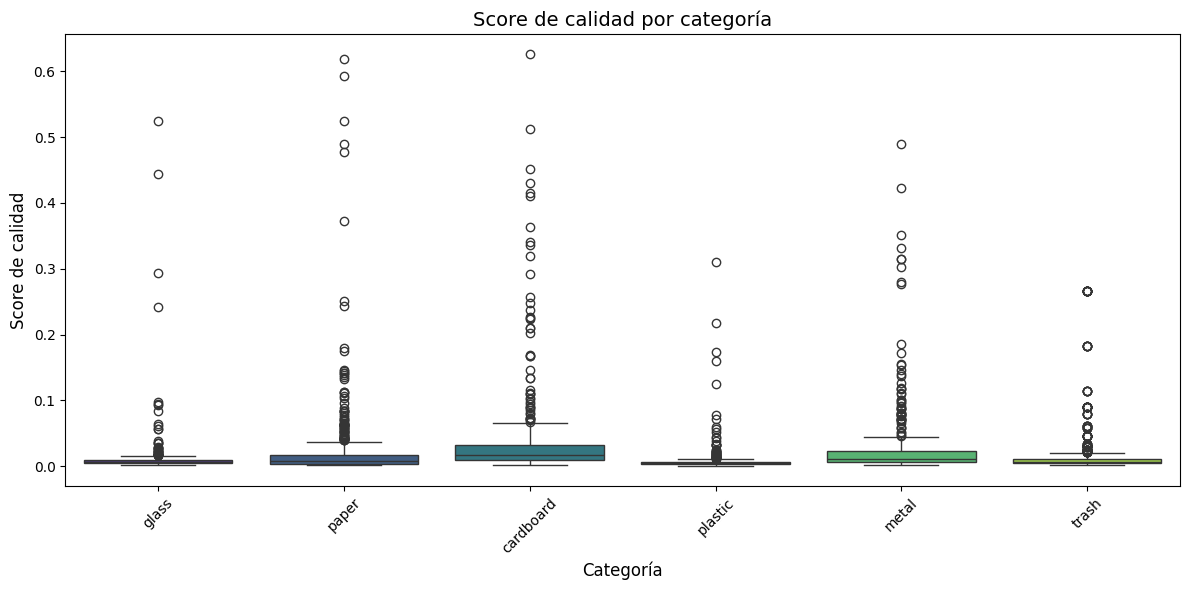


RESUMEN Y CONCLUSIONES
Total de imágenes analizadas: 3439
Características del dataset:
- Resolución promedio: 512.0 x 384.0 píxeles
- Relación de aspecto promedio: 1.33
- Brillo promedio: 163.55/255
- Contraste promedio: 48.45
- Cobertura de bounding box promedio: 52.4%

Estadísticas por categoría:
    category  brightness   contrast  bb_coverage  quality_score
0  cardboard  148.832349  51.741017     0.751536       0.039611
1      glass  169.927338  49.991154     0.459663       0.011718
2      metal  157.851346  56.986738     0.507693       0.028622
3      paper  163.976747  49.511207     0.656533       0.022432
4    plastic  169.996661  39.770118     0.475181       0.008972
5      trash  165.179904  46.513500     0.422413       0.015109


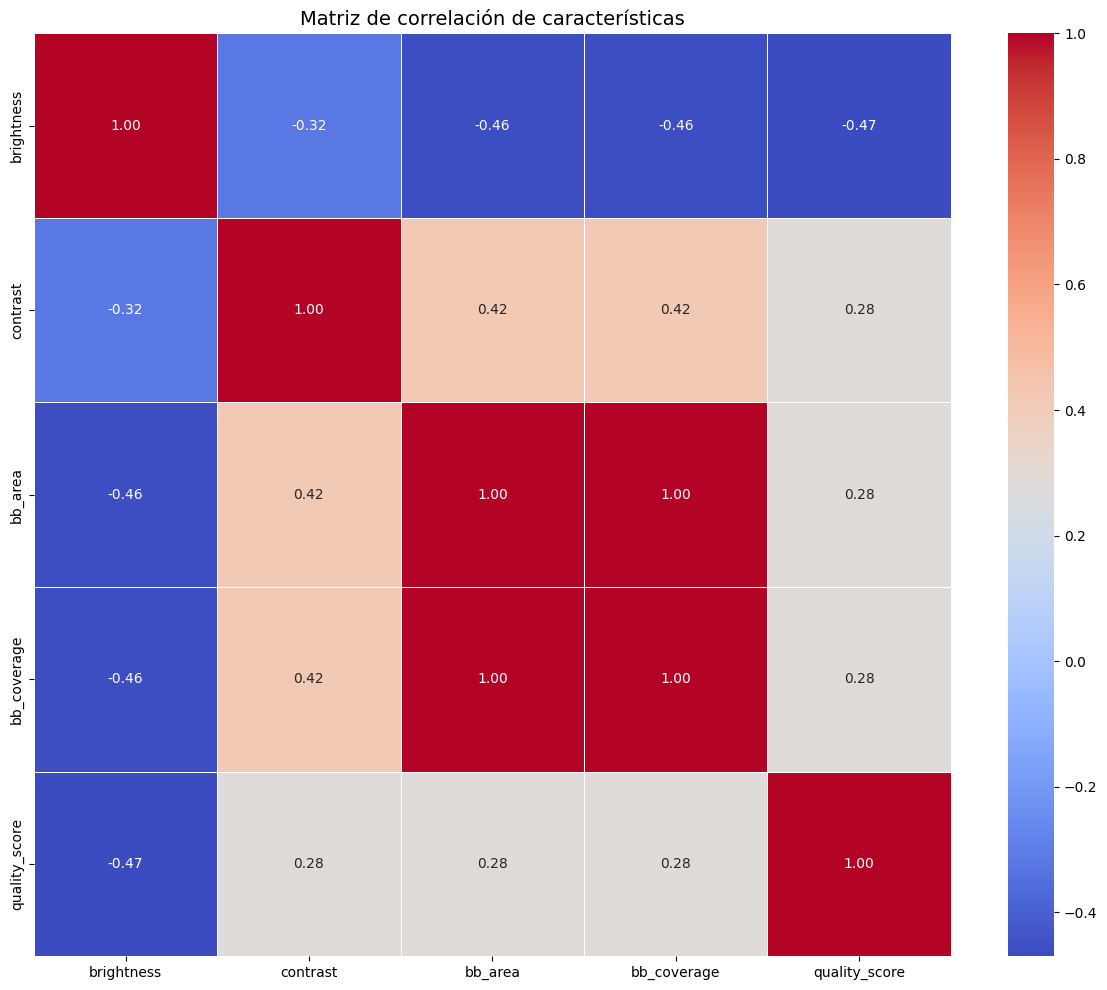

In [22]:
df_images["quality_score"] = df_images["contrast"] / (
    df_images["brightness"].clip(1) * abs(df_images["brightness"] - 128).clip(1)
)

print("Estadísticas de score de calidad:")
print(df_images["quality_score"].describe())

plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="quality_score", data=df_images, palette="viridis")
plt.title("Score de calidad por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Score de calidad", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRESUMEN Y CONCLUSIONES")
print(f"Total de imágenes analizadas: {len(df_images)}")
print("Características del dataset:")
print(
    f"- Resolución promedio: {df_images['width'].mean():.1f} x {df_images['height'].mean():.1f} píxeles"
)
print(f"- Relación de aspecto promedio: {df_images['aspect_ratio'].mean():.2f}")
print(f"- Brillo promedio: {df_images['brightness'].mean():.2f}/255")
print(f"- Contraste promedio: {df_images['contrast'].mean():.2f}")
print(
    f"- Cobertura de bounding box promedio: {df_images['bb_coverage'].mean()*100:.1f}%"
)

category_stats = (
    df_images.groupby("category")
    .agg(
        {
            "brightness": "mean",
            "contrast": "mean",
            "bb_coverage": "mean",
            "quality_score": "mean",
        }
    )
    .reset_index()
)

print("\nEstadísticas por categoría:")
print(category_stats)

plt.figure(figsize=(12, 10))
corr_columns = ["brightness", "contrast", "bb_area", "bb_coverage", "quality_score"]
corr_matrix = df_images[corr_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación de características", fontsize=14)
plt.tight_layout()
plt.show()

## Tratamiento de residuos

Según la clasificación del residuo, se sugieren los siguientes tratamientos por tipo de residuo:
1. Metal
    - Reciclable
    - Tratamiento: Se recolecta, separa (aluminio, acero, etc.) y se funde para reutilizar en la fabricación de nuevos productos.
2. Vidrio (glass)
    - Reciclable indefinidamente
    - Tratamiento: Se tritura, limpia y funde para formar nuevos envases. No pierde calidad.
3. Papel
    - Reciclable (si no está sucio)
    - Tratamiento: Se tritura, mezcla con agua, se prensa y se seca para formar papel reciclado.
4. Basura (trash)
    - No reciclable (mezcla de residuos orgánicos e inorgánicos no tratados)
    - Tratamiento: Se lleva a rellenos sanitarios o plantas de incineración (con o sin recuperación de energía).
5. Cartón (cardboard)
    - Reciclable
    - Tratamiento: Igual que el papel, pero es más grueso y resistente.
6. Plástico
    - Reciclable con clasificación
    - Tratamiento: Se  tritura y se reutiliza.